In [1]:
import urllib.request

# Install XGBoost with GPU support
urllib.request.urlretrieve("https://s3-us-west-2.amazonaws.com/xgboost-wheels/xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl", "/content/xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl")

!pip uninstall xgboost
!pip install xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl


# Use latest version of mlxtend that supports parallel processing
!pip uninstall mlxtend
!pip install mlxtend

# Use LGBM with GPU support
!pip uninstall lightgbm

!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake ../../LightGBM -DUSE_GPU=1
!make -j$(nproc)

!git clone --recursive https://github.com/Microsoft/LightGBM.git
%cd LightGBM/python-package
!python3 setup.py install --gpu

Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.6/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Processing ./xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl
Uninstalling mlxtend-0.14.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/mlxtend-0.14.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/mlxtend/*
Proceed (y/n)? y
  Successfully uninstalled mlxtend-0.14.0
     |████████████████████████████████| 1.3MB 4.8MB/s 
Uninstalling lightgbm-2.2.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/lightgbm-2.2.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/lightgbm/*
Proceed (y/n)? y
  Successfully uninstalled lightgbm-2.2.3
Cloning into 'LightGBM'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (49/49), done.
remote: To

In [410]:
import os
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pprint
import tensorflow as tf
from math import ceil
from datetime import timedelta
from datetime import datetime
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
pd.set_option('display.max_colwidth',1000)

# Version
print(mpl.__version__)  #> 3.0.0
print(sns.__version__)  #> 0.9.0

3.0.3
0.9.0


In [0]:
from google.colab import auth
auth.authenticate_user()

In [412]:
BUCKET = 'training-data-27/datathletes19' #@param {type:"string"}
BUCKET_DATA_DIR = 'data' #@param {type:"string"}
BUCKET_OUTPUT_DIR = 'output' #@param {type:"string"}

print('***** Task data directory: {} *****'.format(BUCKET))

BUCKET_DATA_DIR = 'gs://{}/{}'.format(BUCKET, BUCKET_DATA_DIR)
LOCAL_TASK_DATA_DIR = 'data' 
!test -d $LOCAL_TASK_DATA_DIR || mkdir $LOCAL_TASK_DATA_DIR
!gsutil cp -r -n $BUCKET_DATA_DIR .
!ls $LOCAL_TASK_DATA_DIR


BUCKET_OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, BUCKET_OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(BUCKET_OUTPUT_DIR))

LOCAL_OUTPUT_DIR = 'output'
!test -d $LOCAL_OUTPUT_DIR || mkdir $LOCAL_OUTPUT_DIR


***** Task data directory: training-data-27/datathletes19 *****
Skipping existing item: file://./data/rates.csv
Skipping existing item: file://./data/sample_submission.csv
Skipping existing item: file://./data/test.csv

==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Skipping existing item: file://./data/train.csv
rates.csv  sample_submission.csv  test.csv  train.csv
***** Model output directory: gs://training-data-27/datathletes19/output *****


In [0]:
def add_date_info(dataset):
    #Convert to datetime format
    dataset['departure_date'] = pd.to_datetime(dataset['departure_date'], format='%Y%m%d',exact=True)
    
    dataset['year'] = dataset.departure_date.dt.year.astype(str)
    dataset['week'] = dataset.departure_date.dt.year.astype(str)
#     df['month'] = df.departure_date.dt.month.astype(str)
#     df['day'] = df.departure_date.dt.day.astype(str)
    
    return dataset

def add_arrival_info(dataset):    
    dataset['arrival_date'] = dataset.apply(lambda x: x['departure_date'] + timedelta(hours=x['eft']) + timedelta(hours=x['departure_time'] / 100) + timedelta(minutes=x['departure_time'] % 100),
                                            axis=1)    
    dataset['arrival_time'] = dataset.apply(lambda x: int('%s%s' % (x['arrival_date'].hour, x['arrival_date'].minute)),
                                           axis=1)
    return dataset

In [414]:
df_train = pd.read_csv('{}/train.csv'.format(LOCAL_TASK_DATA_DIR))
df_test = pd.read_csv('{}/test.csv'.format(LOCAL_TASK_DATA_DIR))
df_submission = pd.read_csv('{}/sample_submission.csv'.format(LOCAL_TASK_DATA_DIR))
rates = pd.read_csv('{}/rates.csv'.format(LOCAL_TASK_DATA_DIR), index_col=0, skiprows=0).T.to_dict()

# Add date info
df_train = add_date_info(df_train)
df_test = add_date_info(df_test)

# Add arrival info
df_train = add_arrival_info(df_train)
df_test = add_arrival_info(df_test)

#Changing departure_date into a categorical variable
df_train['departure_date'] = df_train['departure_date'].astype(str)
df_test['departure_date'] = df_test['departure_date'].astype(str)

# Convert time to hour buckets
df_train['departure_time'] = df_train['departure_time'].apply(lambda x: int(x / 300)).astype(str)
df_test['departure_time'] = df_test['departure_time'].apply(lambda x: int(x / 300)).astype(str)
df_train['arrival_time'] = df_train['arrival_time'].apply(lambda x: int(x / 300)).astype(str)
df_test['arrival_time'] = df_test['arrival_time'].apply(lambda x: int(x / 300)).astype(str)

# Replace price with price per passenger
df_train['price'] = df_train['price'] / df_train['number_of_passengers']
df_train['price'] = (df_train.apply(lambda x: (rates[x['currency']]['rate'] * x['price']), axis=1)).round(2)

# Concat origin and destinaiton
df_train['origin_destination'] = df_train['origin'] + '-' + df_train['destination']
df_test['origin_destination'] = df_test['origin'] + '-' + df_test['destination']

df_submission['currency'] = df_test['currency']
df_submission['number_of_passengers'] = df_test['number_of_passengers']

df_train.drop(['currency', 'number_of_passengers', 'search_date', 'arrival_date', 'arrival_time',
               'country'], axis=1, inplace=True)
df_test.drop(['currency', 'number_of_passengers', 'search_date', 'arrival_date', 'arrival_time',
              'country'], axis=1, inplace=True)

df_test.head()

,id,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,year,week,origin_destination
0,100001,LAX,SEA,1537,2019-02-03,2,Sun,61,3.183,AA,M,B,E75,2019,2019,LAX-SEA
1,100002,EWR,MCO,1510,2019-01-14,3,Mon,26,2.900,B6,M,S,320,2019,2019,EWR-MCO
2,100003,EWR,MCO,1510,2019-01-21,2,Mon,31,2.967,NK,M,U,32A,2019,2019,EWR-MCO
3,100004,FLL,JFK,1723,2019-01-01,2,Tue,3,2.817,B6,M,E,321,2019,2019,FLL-JFK
4,100005,PHL,LAS,3494,2018-12-20,6,Thu,15,5.800,NK,M,H,32A,2018,2018,PHL-LAS


In [0]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('price')
quantitative.remove('id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

In [416]:
quantitative

['distance', 'advance_purchase', 'eft']

In [417]:
qualitative

['origin',
 'destination',
 'departure_date',
 'departure_time',
 'departure_day_of_week',
 'carrier',
 'cabin',
 'rbd',
 'aircraft',
 'year',
 'week',
 'origin_destination']

### descriptive statistics summary


In [418]:
df_train.describe()

,id,distance,advance_purchase,eft,price
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,1942.185510,32.282610,3.284765,228.507015
std,28867.657797,1231.382088,38.208828,1.611331,173.686407
min,1.000000,286.000000,0.000000,0.983000,22.680000
25%,25000.750000,1032.000000,8.000000,2.033000,118.055000
50%,50000.500000,1601.000000,19.000000,2.883000,185.200000
75%,75000.250000,2802.000000,40.000000,4.533000,292.547500
max,100000.000000,4340.000000,334.000000,7.000000,7474.200000


In [419]:
df_test.describe()

,id,distance,advance_purchase,eft
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,150000.500000,1956.487240,31.932640,3.302919
std,28867.657797,1237.503018,37.915105,1.619372
min,100001.000000,286.000000,0.000000,0.983000
25%,125000.750000,1032.000000,8.000000,2.050000
50%,150000.500000,1620.000000,19.000000,2.900000
75%,175000.250000,2805.000000,39.000000,4.583000
max,200000.000000,4340.000000,330.000000,7.000000


In [420]:
#standardizing data
price_scaled = StandardScaler().fit_transform(df_train['price'][:,np.newaxis]);
low_range = price_scaled[price_scaled[:,0].argsort()][:10]
high_range= price_scaled[price_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.18505557]
 [-1.18044955]
 [-1.17964349]
 [-1.17440414]
 [-1.17112234]
 [-1.17112234]
 [-1.16824358]
 [-1.16686177]
 [-1.16547996]
 [-1.16478906]]

outer range (high) of the distribution:
[[13.355706  ]
 [13.46619304]
 [15.6587187 ]
 [16.15962396]
 [16.6202265 ]
 [16.6202265 ]
 [16.6202265 ]
 [22.38927331]
 [41.71730738]
 [41.71730738]]


In [421]:
df_train.sort_values(by = 'price', ascending = False)[:5]

,id,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,price,year,week,origin_destination
51949,51950,LAX,JFK,3974,2018-12-29,0,Sat,2,5.367,B6,M,Y,32S,7474.2,2018,2018,LAX-JFK
85044,85045,JFK,LAX,3974,2019-01-02,4,Wed,14,6.367,B6,M,Y,32S,7474.2,2019,2019,JFK-LAX
89622,89623,SFO,JFK,4152,2018-12-02,3,Sun,1,5.633,AA,F,F,32B,4117.2,2018,2018,SFO-JFK
77201,77202,ORD,SFO,2964,2019-01-06,6,Sun,28,4.800,UA,F,J,739,3115.2,2019,2019,ORD-SFO
57156,57157,SFO,ORD,2964,2019-01-06,3,Sun,30,4.267,UA,F,J,739,3115.2,2019,2019,SFO-ORD


In [0]:
# deleting points
df_train.sort_values(by = 'price', ascending = False)[:3]
df_train = df_train.drop(df_train[df_train['id'] == 51950].index)
df_train = df_train.drop(df_train[df_train['id'] == 85045].index)
df_train = df_train.drop(df_train[df_train['id'] == 89623].index)
df_train = df_train.drop(df_train[df_train['id'] == 57157].index)
df_train = df_train.drop(df_train[df_train['id'] == 56666].index)
df_train = df_train.drop(df_train[df_train['id'] == 77202].index)
df_train = df_train.drop(df_train[df_train['id'] == 19741].index)

In [0]:
max_price = df_train['price'].max()

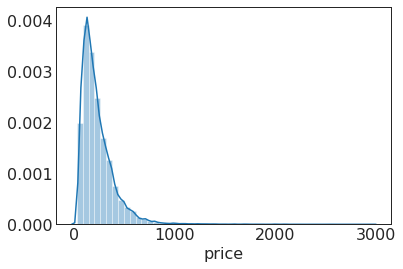

In [424]:
#histogram
sns.distplot(df_train['price']);

In [425]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

Skewness: 2.915599
Kurtosis: 17.483505


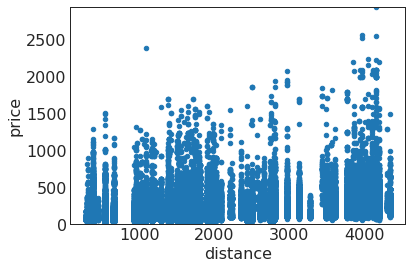

In [426]:
#scatter plot distance/price
var = 'distance'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,max_price));

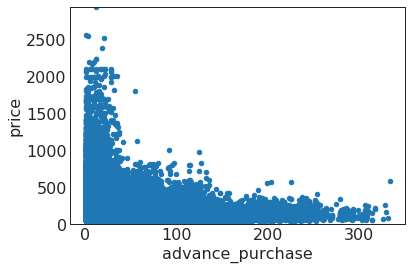

In [427]:
#scatter plot advance_purchase/price
var = 'advance_purchase'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,max_price));

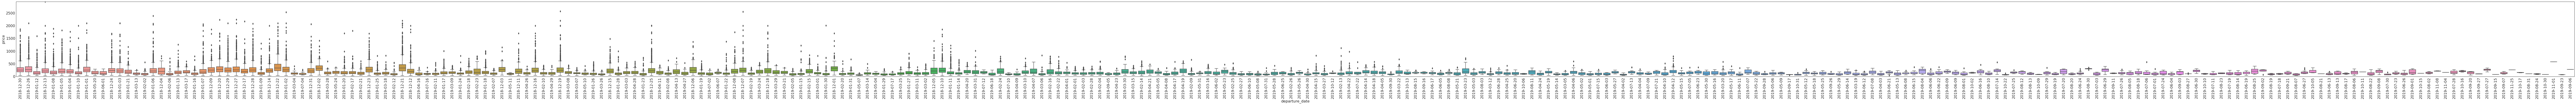

In [428]:
# scatter plot departure_time/price
var = 'departure_date'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(200, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.axis(ymin=0, ymax=max_price);

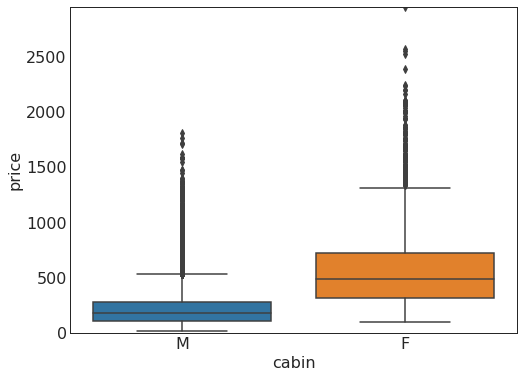

In [429]:
#box plot cabin/price
var = 'cabin'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=max_price);

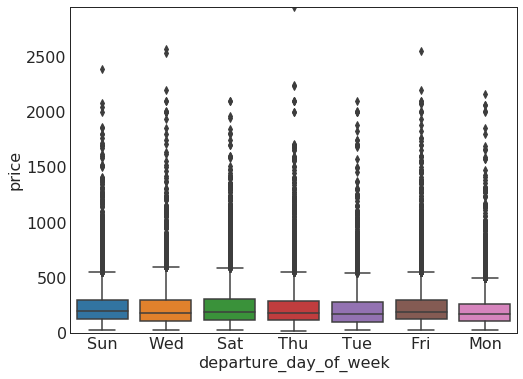

In [430]:
#box plot departure day/price
var = 'departure_day_of_week'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=max_price);

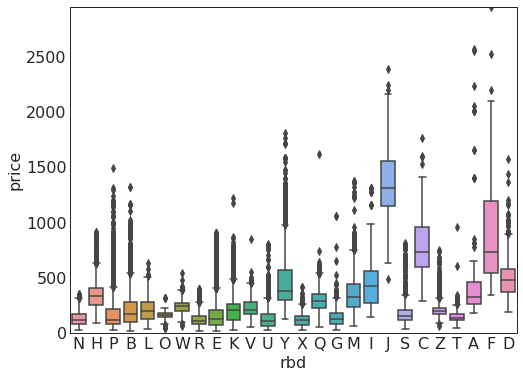

In [431]:
#box plot rbd/price
var = 'rbd'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=max_price);

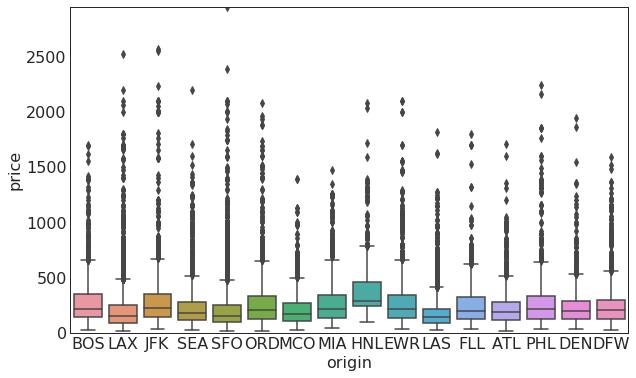

In [432]:
#box plot origin/price
var = 'origin'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=max_price);

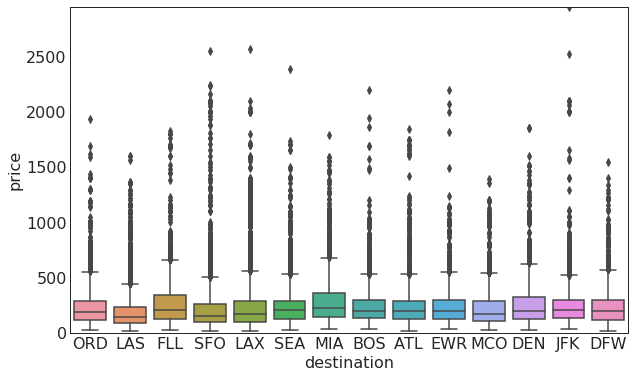

In [433]:
#box plot destination/price
var = 'destination'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=max_price);

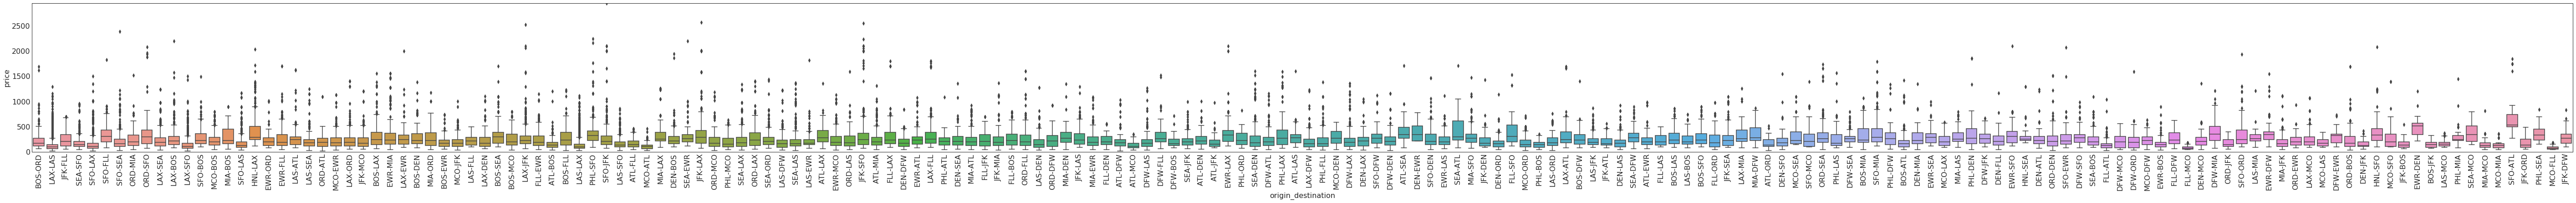

In [434]:
#box plot origin_destination/price
var = 'origin_destination'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(100, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.axis(ymin=0, ymax=max_price);

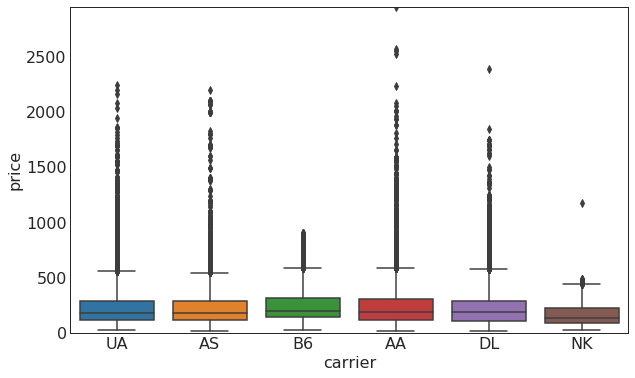

In [435]:
#box plot carrier/price
var = 'carrier'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=max_price);

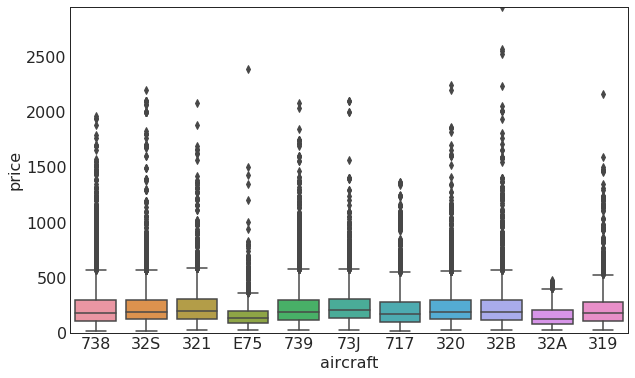

In [436]:
#box plot aircraft/price
var = 'aircraft'
data = pd.concat([df_train['price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=max_price);

In [0]:
#scatterplot
# sns.set()
# cols = ['price', 'distance', 'advance_purchase']
# sns.pairplot(df_train[cols], height = 2.5)
# plt.show();

In [438]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Missing'])
missing_data.head(20)

,Missing
origin_destination,0
advance_purchase,0
origin,0
destination,0
distance,0
departure_date,0
departure_time,0
departure_day_of_week,0
eft,0
week,0


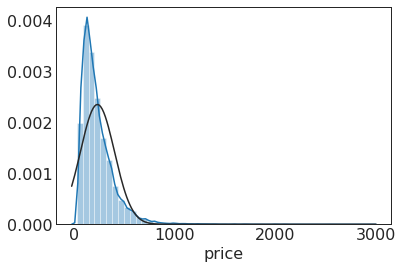

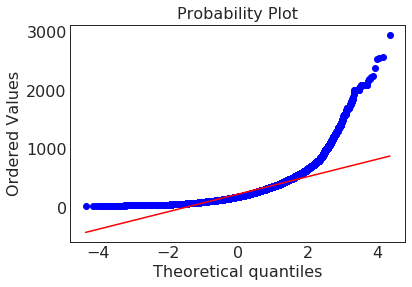

In [439]:
#histogram and normal probability plot
sns.distplot(df_train['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['price'], plot=plt)

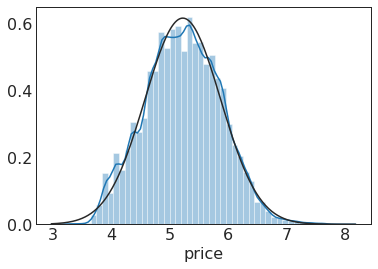

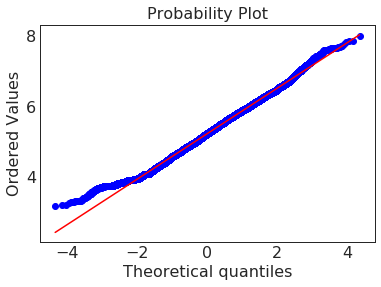

In [440]:
#transformed histogram and normal probability plot
sns.distplot(np.log1p(df_train['price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

In [441]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'price']].groupby(feature).mean()['price']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'__E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(df_train, q)
    qual_encoded.append(q+'__E')
print(qual_encoded)

['origin__E', 'destination__E', 'departure_date__E', 'departure_time__E', 'departure_day_of_week__E', 'carrier__E', 'cabin__E', 'rbd__E', 'aircraft__E', 'year__E', 'week__E', 'origin_destination__E']


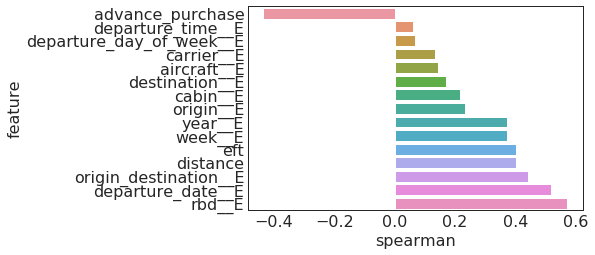

In [442]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['price'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(df_train, features)

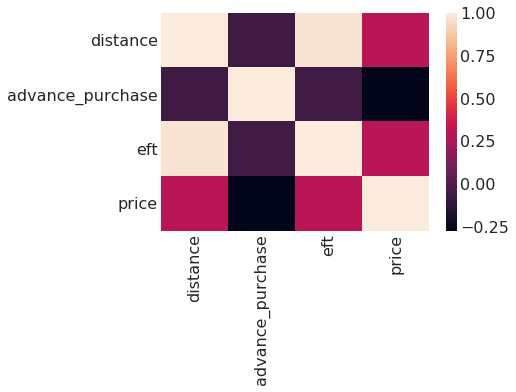

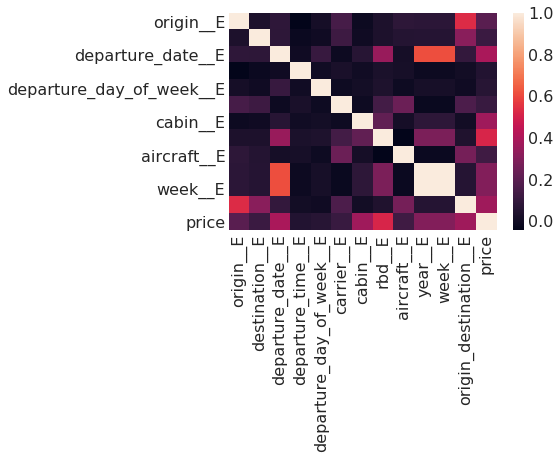

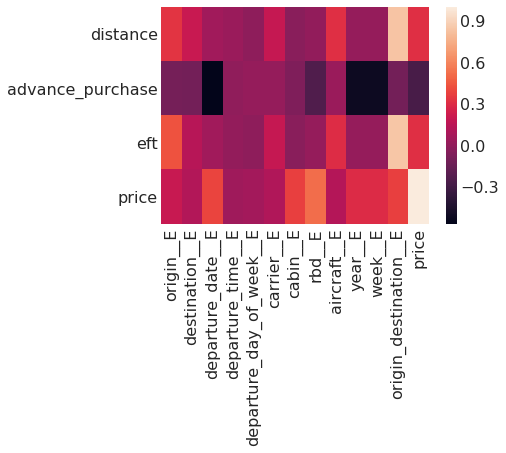

In [443]:
plt.figure(1)
corr = df_train[quantitative+['price']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = df_train[qual_encoded+['price']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['price'], columns=qual_encoded+['price'])
for q1 in quantitative+['price']:
    for q2 in qual_encoded+['price']:
        corr.loc[q1, q2] = df_train[q1].corr(df_train[q2])
sns.heatmap(corr)

### Data processing

In [0]:
#applying log transformation
df_train['price'] = np.log1p(df_train['price'])

In [0]:
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

df_train.reset_index(drop=True, inplace=True)
y = df_train['price'].reset_index(drop=True)

In [0]:
df_train.drop(['departure_date' , 'origin', 'destination'],
              axis=1,
              inplace=True)

df_test.drop(['departure_date', 'origin', 'destination'],
              axis=1,
              inplace=True)

### Features

In [447]:
train_features = df_train.drop(['price'], axis=1)
test_features = df_test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
features.drop(list(features.filter(regex = '__E$')), axis = 1, inplace = True)

In [449]:
features.shape

(199993, 12)

In [450]:
features.head()

,advance_purchase,aircraft,cabin,carrier,departure_day_of_week,departure_time,distance,eft,origin_destination,rbd,week,year
0,18,738,M,UA,Sun,2,1390,2.850,BOS-ORD,N,2018,2018
1,1,32S,M,AS,Wed,4,380,1.250,LAX-LAS,H,2018,2018
2,23,321,M,B6,Sat,7,1723,3.117,JFK-FLL,P,2019,2019
3,4,32S,M,AS,Thu,3,1093,2.267,SEA-SFO,B,2018,2018
4,8,E75,M,AA,Tue,2,543,1.717,SFO-LAX,L,2019,2019


In [0]:
objects = []

for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [0]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [453]:
skew_features

advance_purchase    2.554889
eft                 0.694564
distance            0.584106
dtype: float64

In [0]:
# TODO: Look at other derived features

In [455]:
features.shape

(199993, 12)

In [456]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(199993, 255)

In [457]:

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

X.head()

,advance_purchase,distance,eft,aircraft_319,aircraft_320,aircraft_321,aircraft_32A,aircraft_32B,aircraft_32S,aircraft_717,aircraft_738,aircraft_739,aircraft_73J,aircraft_E75,cabin_F,cabin_M,carrier_AA,carrier_AS,carrier_B6,carrier_DL,carrier_NK,carrier_UA,departure_day_of_week_Fri,departure_day_of_week_Mon,departure_day_of_week_Sat,departure_day_of_week_Sun,departure_day_of_week_Thu,departure_day_of_week_Tue,departure_day_of_week_Wed,departure_time_0,departure_time_1,departure_time_2,departure_time_3,departure_time_4,departure_time_5,departure_time_6,departure_time_7,origin_destination_ATL-BOS,origin_destination_ATL-DEN,origin_destination_ATL-DFW,...,origin_destination_SFO-DFW,origin_destination_SFO-EWR,origin_destination_SFO-FLL,origin_destination_SFO-JFK,origin_destination_SFO-LAS,origin_destination_SFO-LAX,origin_destination_SFO-MCO,origin_destination_SFO-MIA,origin_destination_SFO-ORD,origin_destination_SFO-SEA,rbd_A,rbd_B,rbd_C,rbd_D,rbd_E,rbd_F,rbd_G,rbd_H,rbd_I,rbd_J,rbd_K,rbd_L,rbd_M,rbd_N,rbd_O,rbd_P,rbd_Q,rbd_R,rbd_S,rbd_T,rbd_U,rbd_V,rbd_W,rbd_X,rbd_Y,rbd_Z,week_2018,week_2019,year_2018,year_2019
0,3.474350,23.822044,1.074277,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0.720123,15.436904,0.705841,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,3.800975,25.532883,1.115586,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1.759924,22.026571,0.968917,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,2.483998,17.446143,0.843176,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [458]:
l = list(final_features.columns.values);
print(set([x for x in l if l.count(x) > 1]))

set()


In [0]:
kfolds = KFold(n_splits=10, shuffle=False, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kfolds))
    return (rmse)

def mape(y, y_pred): 
    return np.mean(np.abs((np.expm1(y) - np.expm1(y_pred)) / np.expm1(y))) * 100

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

#### Ridge


In [0]:
alphas_alt = [0.5]
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

#### Lasso

In [0]:
alphas2 = [5e-05]
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds, n_jobs=-1))

In [463]:
rfr = RandomForestRegressor(bootstrap=True,
                                 criterion='mse',
                                 max_depth=None,
                                 max_features='auto',
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 min_samples_leaf=1,
                                 min_samples_split=2,                                 
                                 min_weight_fraction_leaf=0.0,
                                 n_estimators=100,
                                 n_jobs=-1,                                 
                                 oob_score=False,
                                 random_state=42,
                                 verbose=1,
                                 warm_start=False)

rfr.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


In [464]:
predictions = rfr.predict(np.array(X_test))
print(predictions)
mape(y_test, predictions)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s


[5.07012754 4.76762771 4.8932996  ... 4.26012965 4.85721684 4.63901548]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


10.690671924412769

#### LGBM

In [465]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=1000,
                                       max_depth=-1,
                                       learning_rate=0.15,
                                       n_estimators=1000,
                                       max_bin=100, 
                                       bagging_fraction=1,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=1,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       device_type='gpu')


print('LGBMRegressor', datetime.now())
lgb_model = lightgbm.fit(X_train, y_train)
print('MAPE score on test data:')
mape(y_test, (lgb_model_full_data.predict(X_test)))

LGBMRegressor 2019-06-21 06:43:14.941908
MAPE score on test data:


11.366881073314637

In [0]:
xgboost = XGBRegressor(learning_rate=0.15,n_estimators=1000,
                                     max_depth=10, min_child_weight=0,
                                     gamma=0, subsample=1,
                                     colsample_bytree=1,
                                     objective='reg:linear', nthread=1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0,
                                     tree_method='gpu_hist',
                                     criterion='mae',
                                     verbosity=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
print('xgboost', datetime.now())
xgb_model = xgboost.fit(X_train, y_train)
print('MAPE score on train data:')
print(mape(y_test, (xgb_model.predict(X_test))))

MAPE score on train data:
10.68569217095647


In [0]:
# stack
# stack_gen = StackingCVRegressor(regressors=(ridge,
#                                             gbr, xgboost, lightgbm),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True,
#                                 n_jobs=-1)

In [0]:
def blend_models_predict(X):
#     return ((.2 * xgb_model_full_data.predict(X)) + \
#             (.2 * lgb_model_full_data.predict(X)) + \
#             (.2 * ridge_model_full_data.predict(X)) + \
#             (.1 * gbr_model_full_data.predict(X)) + \
#             (.3 * stack_gen_model.predict(np.array(X))))
    return ((.3 * lgb_model.predict(X)) + \
            (.35 * xgb_model.predict(X)) + \
                (.35 * rfr.predict(X)))

In [479]:
print('MAPE score on validation data:')
print(mape(y_test, blend_models_predict(X_test)))

MAPE score on validation data:


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s


10.095344030931221


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


In [0]:
# score = cv_rmse(ridge)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(lasso)
# print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


# score = cv_rmse(lightgbm)
# print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [480]:
print('*** START Fit ***')

print('xgboost', datetime.now())
xgb_model_full_data = xgboost.fit(X, y)

print('RandomForest', datetime.now())
rfr_model_full_data = rfr.fit(X, y)

print('lightgbm', datetime.now())
lgb_model_full_data = lightgbm.fit(X, y)

# print('ridge', datetime.now())
# ridge_model_full_data = ridge.fit(X, y)

# print('lasso', datetime.now())
# lasso_model_full_data = lasso.fit(X, y)

# print('gbr', datetime.now())
# gbr_model_full_data = gbr.fit(X, y)

# print('StackingCVRegressor', datetime.now())
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('*** Finished Fit ***', datetime.now())

*** START Fit ***
xgboost 2019-06-21 06:55:00.335657
RandomForest 2019-06-21 06:55:52.826187


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


lightgbm 2019-06-21 06:58:01.111165
*** Finished Fit *** 2019-06-21 06:59:30.430003


In [483]:
# print('RMSLE score on train data:')
# print(rmsle(y, blend_models_predict(X)))

print('MAPE score on train data:')
print(mape(y, blend_models_predict_full(X)))

MAPE score on train data:


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s


3.124484711380995


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.7s finished


In [0]:
def blend_models_predict_full(X):
#     return ((.2 * xgb_model_full_data.predict(X)) + \
#             (.2 * lgb_model_full_data.predict(X)) + \
#             (.2 * ridge_model_full_data.predict(X)) + \
#             (.1 * gbr_model_full_data.predict(X)) + \
#             (.3 * stack_gen_model.predict(np.array(X))))
    return ((.3 * lgb_model_full_data.predict(X)) + \
            (.35 * xgb_model_full_data.predict(X)) + \
                (.35 * rfr_model_full_data.predict(X)))

In [485]:
print('Predict submission')
df_submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict_full(X_sub)))

Predict submission


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.5s finished


In [0]:
df_submission['price'] = (df_submission.apply(lambda x: (x['price'] / rates[x['currency']]['rate']), axis=1)).round(2)
df_submission['price'] = df_submission['price'] * df_submission['number_of_passengers']
df_submission.to_csv('{}/sample_submission.csv'.format(LOCAL_OUTPUT_DIR), mode='w', columns=['id', 'price'], index=False)

In [487]:
df_submission.head()

,id,price,currency,number_of_passengers
0,100001,14142.86,INR,2
1,100002,480.00,USD,4
2,100003,316.00,USD,4
3,100004,2204.00,USD,4
4,100005,359.00,USD,1


In [488]:
!gsutil cp -r $LOCAL_OUTPUT_DIR/* $BUCKET_OUTPUT_DIR/

Copying file://output/sample_submission.csv [Content-Type=text/csv]...
/ [1 files][  1.3 MiB/  1.3 MiB]                                                
Operation completed over 1 objects/1.3 MiB.                                      


In [0]:
# xgb_model_full_data = xgboost.fit(X, y)

print("XGBoost")
df_submission.iloc[:,1] = np.floor(np.expm1(xgb_model_full_data.predict(X_sub)))
df_submission['price'] = (df_submission.apply(lambda x: (x['price'] / rates[x['currency']]['rate']), axis=1)).round(2)
df_submission['price'] = df_submission['price'] * df_submission['number_of_passengers']
df_submission.head()

In [0]:
# lgb_model_full_data = lightgbm.fit(X, y)

print("LGBM")
df_submission.iloc[:,1] = np.floor(np.expm1(lgb_model_full_data.predict(X_sub)))
df_submission['price'] = (df_submission.apply(lambda x: (x['price'] / rates[x['currency']]['rate']), axis=1)).round(2)
df_submission['price'] = df_submission['price'] * df_submission['number_of_passengers']
df_submission.head()

In [0]:
# i

print("rigde")
df_submission.iloc[:,1] = np.floor(np.expm1(ridge_model_full_data.predict(X_sub)))
df_submission['price'] = (df_submission.apply(lambda x: (x['price'] / rates[x['currency']]['rate']), axis=1)).round(2)
df_submission['price'] = df_submission['price'] * df_submission['number_of_passengers']
df_submission.head()

In [0]:
print("GBR")
df_submission.iloc[:,1] = np.floor(np.expm1(gbr_model_full_data.predict(X_sub)))
df_submission['price'] = (df_submission.apply(lambda x: (x['price'] / rates[x['currency']]['rate']), axis=1)).round(2)
df_submission['price'] = df_submission['price'] * df_submission['number_of_passengers']
df_submission.head()

In [0]:
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print("Stack")
df_submission.iloc[:,1] = np.floor(np.expm1(stack_gen_model.predict(np.array(X_sub))))
df_submission['price'] = (df_submission.apply(lambda x: (x['price'] / rates[x['currency']]['rate']), axis=1)).round(2)
df_submission['price'] = df_submission['price'] * df_submission['number_of_passengers']
df_submission.head()